**Project Statement:**

Portobello Tech is an app innovator who has devised an intelligent way of predicting employee turnover within the company. It periodically evaluates employees' work details, including the number of projects they worked on, average monthly working hours, time spent in the company, promotions in the last five years, and salary level.

Data from prior evaluations shows the employees’ satisfaction in the workplace. The data could be used to identify patterns in work style and their interest in continuing to work for the company.

The HR Department owns the data and uses it to predict employee turnover. Employee turnover refers to the total number of workers who leave a company over time.

As the ML Developer assigned to the HR Department, you have been asked to create ML programs to:

1.    Perform data quality checks by checking for missing values, if any.
2.    Understand what factors contributed most to employee turnover at EDA.
3.    Perform clustering of employees who left based on their satisfaction and evaluation.
4.    Handle the left Class Imbalance using the SMOTE technique.
5.    Perform k-fold cross-validation model training and evaluate performance.
6.    Identify the best model and justify the evaluation metrics used.
7.    Suggest various retention strategies for targeted employees.

**Employee Turnover Classification project**

**EDA**

Exploratory Data Analysis
no missing values found
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   dept                   14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


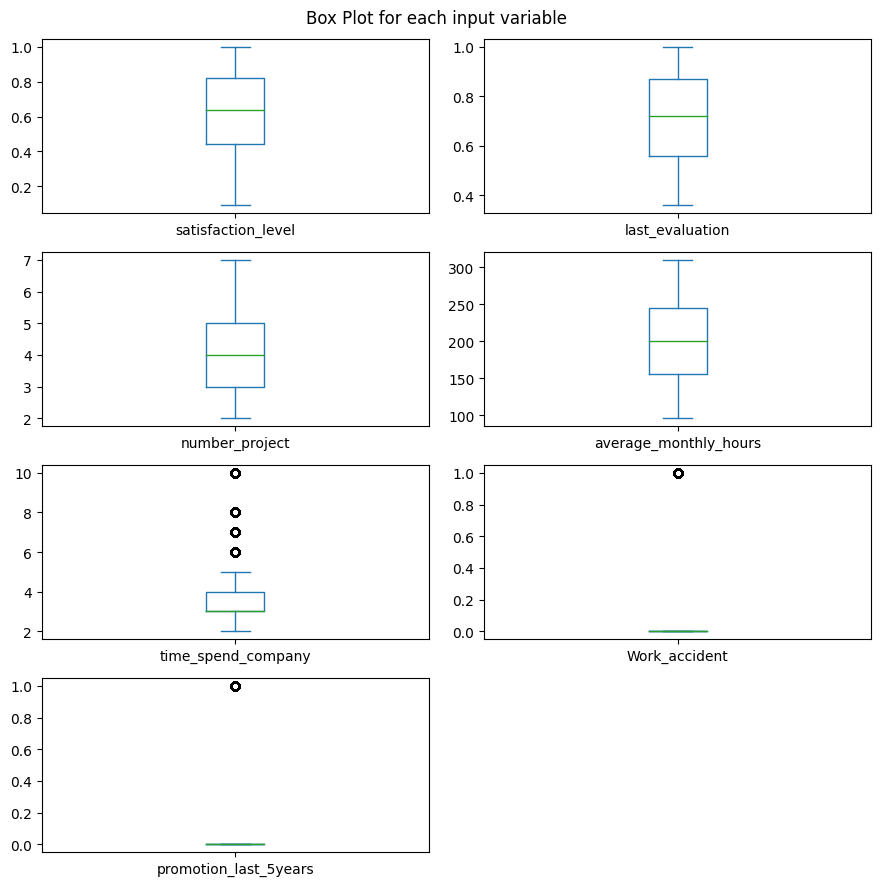

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier



#some print formatting constants
BOLD_START = '\033[1m'
END = '\033[0m'
UNDERLINE = '\033[4m'
DARKCYAN = '\033[36m'

models = {
    "LR" : LogisticRegression(random_state=123),
    "RF" : RandomForestClassifier(),
    "GB" : GradientBoostingClassifier()
}

params_grid = {

    "LR" : {'model__C' :[x/10 for x in range(1,11)],'model__max_iter' : [10000]},

    "RF" :{'model__n_estimators' : range(50,100,10),'model__bootstrap':[False]},

    "GB" :{'model__n_estimators' : range(50,100,10),'model__learning_rate':[0.1]},
}

print('%s%s%s%s%s' %(BOLD_START,UNDERLINE,DARKCYAN,'Exploratory Data Analysis',END))
# this is the same data as provided in the assignment.
url = 'https://raw.githubusercontent.com/tksundar/employee_turnover/refs/heads/master/HR_comma_sep.csv'

hr_data = pd.read_csv(url,header=0,skip_blank_lines=True, skipinitialspace=True)
#check for missing values
if hr_data.isna().sum().any():
    print('missing values found')
else:
    print('no missing values found')

#the column sales has to be renamed to dept
hr_data.rename(columns = {'sales':'dept'},inplace = True)
# we willl also fix a typo in the column name
hr_data.rename(columns = {'average_montly_hours':'average_monthly_hours'},inplace = True)

hr_data.info()
# lets look if the data has many outliers
hr_data.drop(['dept','salary','left'], axis=1).plot(kind='box', subplots=True, layout=(4,2), sharex=False, sharey=False, figsize=(9,9),
                                      title='Box Plot for each input variable')
plt.tight_layout()
plt.show()

We have outliers . We will need to fix them if we are going to use K Means Clustering, as these outliers can affect the accuracy of the algorithm's cluster predictions

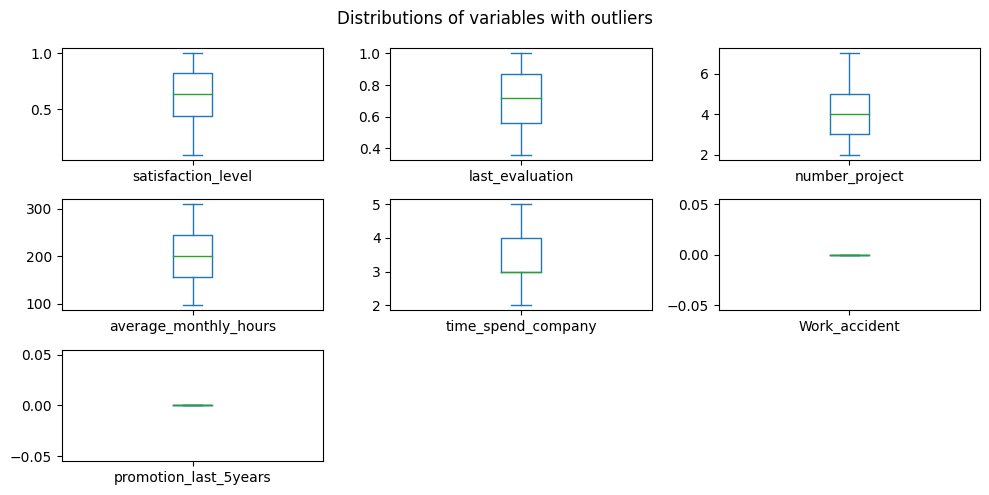

In [34]:
import numpy as np

def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    outliers = []
    for i in data:
        if i < lwr_bound or i > upr_bound:
            outliers.append(i)
    return outliers


def remove_outliers(data, outlier_columns):

  for column in outlier_columns:
      array = data[column]
      outliers = detect_outliers_iqr(array)
      value = np.median(array)
      for i in outliers:
          # for every i(outlier) in array , replace it by value else retain the same array element
          array = np.where(array == i, value, array)
          data[column] = np.asarray(array)

  return data

outlier_columns = hr_data.select_dtypes(include=['number']).drop('left', axis =1).columns
hr_data = remove_outliers(hr_data, outlier_columns)

data = hr_data.loc[:,outlier_columns]
data.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,5), legend='top',
                                      title='Distributions of variables with outliers')

plt.tight_layout()
plt.show()

Outliers replaced ! Note that work accident numbers and number  of zero promotion in the last 5 years were both outliers. After out;ier removal , these numbers have become 0. We can therefore drop these columns from further analysis

In [ ]:
hr_data.drop(['Work_accident','promotion_last_5years'], axis = 1, inplace=True)
print('columns dropped')

Consolidating some dept values to reduce dimenionalirt after onehot/dummy encoding

In [ ]:

hr_data['dept']=np.where(hr_data['dept'] =='support', 'technical', hr_data['dept'])
hr_data['dept']=np.where(hr_data['dept'] =='IT', 'technical', hr_data['dept'])
print(hr_data['dept'].unique())
hr_data.describe()


**Which dept has the maximum turnover?**

In [ ]:
pd.crosstab(hr_data.dept,hr_data.left).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('dept')
plt.ylabel('Frequency of Turnover')
plt.tight_layout()
plt.show()

Technical and sales people are high risk departments

**Is salary a factor in employee turnover?**

In [ ]:
pd.crosstab(hr_data.salary, hr_data.left,normalize='index').plot(kind='bar',stacked=True)
plt.title('Bar Chart of Salary Level vs Turnover')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

No surprises here. Lower the salary, greater the turnover

**Does number or projects have an impact on employee turnover?**

In [ ]:
pd.crosstab(hr_data.number_project, hr_data.left,normalize='index').plot(kind='bar',stacked=True)
plt.title('Bar Chart of number of projects vs Turnover')
plt.xlabel('Number of projects')
plt.ylabel('Proportion of Employees')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Too few of too many projects is a factor affecting employee turnover

**How about length of service?**

In [ ]:
pd.crosstab(hr_data.time_spend_company, hr_data.left,normalize='index').plot(kind='bar',stacked=True)
plt.title('Bar Chart of time spent vs Turnover')
plt.xlabel('Time Spent')
plt.ylabel('Proportion of Employees')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

This is interesting. Employeess tend to leave after two years and if they spend more than 6 years, they are staying put.

**Correlations - Heatmap**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

#encode the salary data
categories = hr_data['salary'].unique()
enc = OrdinalEncoder(categories=[categories])
hr_data['salary'] = enc.fit_transform(pd.DataFrame(hr_data['salary']))
plt.figure(figsize=(10,10))
sns.heatmap(hr_data.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.title('Heatmap of numerical columns')
plt.show()
hr_data.head()

satisfaction_level has a medium negative correlation with employee leaving.

**Distributions**

In [ ]:
hr_data.drop(['left'],axis=1).loc[:,['satisfaction_level','last_evaluation','average_monthly_hours']].hist(bins=30,figsize = (12,6),layout=(1,3))
plt.suptitle('Histogram of feature columns')
plt.show()

We have already seen that the above columns do not have outliers

**Clustering**


**Initial Scatter plot**

In [ ]:
plt.figure(figsize=(8,8))
df = pd.DataFrame(hr_data)
df['left'] = df['left'].apply(lambda x: 'Stayed' if x==0 else 'Left')
sns.scatterplot(data=df,x='satisfaction_level',y='last_evaluation',hue='left', palette= ['orange','skyblue'])
plt.title('scatter plot for key features')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



Looking at the above plot,we see employees leaving for a wide range of satisfaction_level and last_evaluation. However we can also see 3 concentrated regions of employee leaving, but it is not obviuos how many clusters will be optimum for k means clustering. So we will use the elbow curve to find out

**Elbow Curve and Silhouette Scores**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
sum_squared_errors = []
sil_score = []
for k in range(2,11):
  km = KMeans(n_clusters=k, random_state=42,n_init = 10)
  labels = km.fit_predict(df)
  sil_score.append(silhouette_score(df,labels))
  sum_squared_errors.append(km.inertia_)
plt.subplot(1,2,1)
plt.plot(range(2,11),sum_squared_errors)
plt.xticks(range(2,11))
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.title('Elbow curve')
plt.subplot(1,2,2)
plt.plot(range(2,11),sil_score)
plt.xticks(range(2,11))
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()



According to silhouette scores , K =2 is the best!!! Elbow curve does not indicate any clear elbow point, though we can see a weak elbow at 3 and 6. I will examine the clustering for k = 2,3,4 and 5. Also, silhouette scores do not always provide the best cluster number. It makes lot of assumptions about data. Here is what Gemini has to say about silhouette scores https://g.co/gemini/share/4ac37c160774

**Analysis by cluster numbers**

In [ ]:

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
k_values = [2,3,4,5]

def plotbar(y):
  fig,axes = plt.subplots(1,len(k_values),figsize=(16,4),layout='tight')

  for i,k in enumerate(k_values):
      km = KMeans(n_clusters=k,random_state=42,n_init='auto')
      km.fit(df)
      df['cluster'] = km.predict(df)
      df_cluster_wise = pd.DataFrame(df.groupby('cluster').mean()).reset_index()
      # df_ = df.copy(deep = True)
      # df_['left'] = df_['left'].apply(lambda x: 'Stayed' if x==0 else 'Left')
      # freq = pd.crosstab(df_['cluster'],df_['left'])
      # print(f'cluster = {k}')
      # print('{}\n'.format(freq))
      bars = sns.barplot(data = df_cluster_wise,x='cluster',y=y ,hue='left',ax=axes[i])
      bars.legend(loc='upper left', bbox_to_anchor=(1, 1))
      bars.set_title(f'k = {k}')
  plt.suptitle(f'bar plot for {y} for different clusters')
  plt.show()

plotbar('satisfaction_level')
plotbar('last_evaluation')



We can see that while low satisfaction level leads to greater employee turnover(cluster 2) , a higher satisfaction level does not automatically guarantee retention if the emplyee is not evaluated periodically. Employees with higher last evaluation periods(not evaluated recently) have left despite otheriwse having a high satisfaction level as seen for clusters 3, 4 and 5

**Scatter Plot for various clusters**

In [ ]:

from sklearn.metrics import silhouette_score
from warnings import simplefilter
# ignore all warnings
simplefilter(action='ignore')

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
k_values = [2,3,4,5]
fig,axes = plt.subplots(1,len(k_values),figsize=(18,8),layout='constrained')
colors = ['red','green','blue','purple']
for i,k in enumerate(k_values):
  km = KMeans(n_clusters=k,random_state=42)
  km.fit(df)
  df['cluster'] = km.predict(df)
  s_score = silhouette_score(df,km.labels_)
  cluster_centers = km.cluster_centers_
  new_df = pd.DataFrame(df)
  new_df['left'] = df['left'].apply(lambda x: 'Left' if x==1 else 'Stayed')
  axe = sns.scatterplot(data=new_df,x='satisfaction_level',y='last_evaluation',hue='left',ax=axes[i], palette = ['orange','skyblue'])
  axe.set_title(f'k = {k}')
  axe.set_xlabel('satisfaction_level')
  axe.set_ylabel('last_evaluation')
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='o',s=100,c=colors[i],label= 'cluster centers')
  axe.legend(loc='upper left', bbox_to_anchor=(1, 1))
  axe.set_title(f'k = {k}')
plt.suptitle('scatter plot for key features for different k values')
plt.show()




K=5 captures the 3 dense clusters of employee leaving in additon to 2 sparse clusters. At all k values we can see that those with a satisfaction_level around 0.5 or less have left. However with 5 clusters, we can also see that a high satisfaction_level and no recent evaluation( high last_evaluation) have also tended to leave. Those who stayed appear to be those whose satisfaction level was average and whose last_evaluation was also neither too old nor too recent.

The random_state parameter determines the output to a large extent. So the above clustering may not be the same for a different random_state





**Handle the left Class Imbalance using the SMOTE technique**




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
class_values = pd.DataFrame(hr_data.value_counts('left')).reset_index()
print(type(class_values))
print(class_values)
print('\nCount Plot\n')
colors = ['skyblue', 'orange']
barplot = sns.barplot(data=class_values,x='left',y='count')
for bar,color in zip(barplot.patches,colors):
    bar.set_color(color)
plt.title('Count Plot for employess who stayed and who left')
plt.xlabel('Employee Turnover')
plt.ylabel('count')
plt.xticks([0,1],['stayed','left'])
plt.show()

#### Data is  unbalanced and biased towards the majority class(retention or 0 outcomes).  ####

**Encode Categorical Data**







In [ ]:
# we can do all of the above in one line of code as the dataset contains just
# one categorical column, viz., dept. We have already encoded the salary column
# values(low, medium,high)with OrdinalEncoder when generating heatmaps

hr_data = pd.get_dummies(hr_data,dtype=int)
print(hr_data.info())


**SMOTE resampling**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=123)
X = hr_data.drop('left',axis=1)
y = hr_data['left']
print(hr_data.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123) # 80/20 split

print("Before OverSampling, counts of label '1' in train data: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': in train data {}".format(sum(y_train == 0)))
X_train,y_train = sm.fit_resample(X_train,y_train)

print("After OverSampling, counts of label '1' in train data: {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': in train data {}".format(sum(y_train == 0)))


SMOTE analysis has increased the minority class training sample size to the same as that of the majority class.

**5 fold cross validation and performance evaluation**

The problem statement explicitly mentions KFold cross validation. It is not clear whether cross validation in gridsearch is enough(in my opinion, this should be enough as it is using KFold internally) or we need to use Kfold class again. To avoid ambiguity,I am passing the KFold object to the grid search








In [ ]:

from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,roc_auc_score,classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

esitmators = {}

def plot_classification_report(estimator,X_test,y_test,model_name=None):
    precision_1 = precision_score(y_test,estimator.predict(X_test))
    recall_1 = recall_score(y_test,estimator.predict(X_test))
    f1_1 = f1_score(y_test,estimator.predict(X_test))

    precision_0 = precision_score(y_test,estimator.predict(X_test),pos_label=0)
    recall_0 = recall_score(y_test,estimator.predict(X_test),pos_label=0)
    f1_0 = f1_score(y_test,estimator.predict(X_test),pos_label=0)

    cl_report_dict = {
        'left' : [0,1],
        'precision':[precision_0,precision_1],
        'recall':[recall_0,recall_1],
        'f1':[f1_0,f1_1]
    }

    df = pd.DataFrame(cl_report_dict)
    sns.heatmap(df,annot=True,cmap='Blues')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.suptitle('Classification report for {}'.format(model_name))
    plt.show()


def grid_search_cv(model_key,X_train,y_train,cv=None):
    '''
    the 4th param is a cross validation splitter object

    '''
    print(f'\nPerforming grid search with {cv.get_n_splits(X_train)} fold cross validation. Please wait...')
    model = models[model_key]
    param_grid = params_grid[model_key]
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid_search = GridSearchCV(pipeline,param_grid,scoring='accuracy',cv=cv)
    grid_search.fit(X_train,y_train)
    print('%s%s%s'%(BOLD_START,'Best scores and Best Params\n',END))
    print('best score = {}'.format(grid_search.best_score_))
    print('best params = {}'.format(grid_search.best_params_))
    return grid_search

def evaluate_performance(model_key,X_train,y_train,X_test, model_name=None):

    print('%s%s%s%s%s' %(BOLD_START,UNDERLINE,DARKCYAN,'\nEvaluating performance for {}'.format(model_name),END))
    kfold = KFold(n_splits=5,shuffle=True,random_state=123)
    gs_result = grid_search_cv(model_key,X_train,y_train,cv = kfold)
    estimator = gs_result.best_estimator_
    global esitmators
    esitmators[model_key] = estimator
    cl_report = classification_report(y_test,estimator.predict(X_test))
    print('%s%s%s'%(BOLD_START,'\nClassification Report:',END))
    print(cl_report)

    accuracy = accuracy_score(y_test,estimator.predict(X_test))
    roc_auc  = roc_auc_score(y_test,estimator.predict(X_test))
    print('%s%s%s'%(BOLD_START,'Accuracy and roc_auc scores:',END))
    print('accuracy = %0.4f, roc_auc = %0.4f'%(accuracy,roc_auc))
    print()
    plot_classification_report(estimator,X_test,y_test,model_name=model_name)

evaluate_performance('LR',X_train,y_train,X_test,model_name='Logistic Regression')
evaluate_performance('RF',X_train,y_train,X_test,model_name='Random Forest Classifier')
evaluate_performance('GB',X_train,y_train,X_test,model_name='Gradient Boosting Classifier')

The above output show that the Random Forest Classifier performs best with respect to all the metrics.





**ROC_AUC curve and Confusion Matrix**

In [ ]:
from sklearn.metrics import roc_curve,auc,confusion_matrix,ConfusionMatrixDisplay
def plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name=None):
    print('%s%s%s%s'%(BOLD_START,DARKCYAN,'\nEvaluating and visualizing ROC_AUC curve and Confusion Matrix for {}\n'.format(model_name),END))
    y_pred_test = pipeline.predict(X_test)
    y_pred_test_prob = pipeline.predict_proba(X_test)
    # plot confusion matrix
    print('Plotting confusion matrix\n')
    cm = confusion_matrix(y_test,y_pred_test)
    print('confusion matrix\n',cm)
    display_labels = ['stayed','left']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
    disp.plot()
    plt.suptitle('Confusion Matrix for {}'.format(model_name))
    plt.show()

    # plot ROC_AUC curve
    print('Plotting ROC_AUC curve\n')
    # we need the probability of 1s which is the second column(index 1)
    y_positive_probability = y_pred_test_prob[:,1]
    result_df = pd.DataFrame({'Actual_label': y_test, 'Pred_label': y_pred_test, 'Pred_prob': y_positive_probability})
    fpr,tpr,threshold = roc_curve(y_test, y_positive_probability)
    area_under_curve = auc(fpr,tpr)
    print('auc = {}\n'.format(area_under_curve))
    plt.plot(fpr,tpr,label=f'ROC curve , AUC = {area_under_curve:.4f}')
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    title_ = 'ROC curve for various thresholds for {}'.format(model_name)
    plt.title(title_)
    plt.legend(loc = 'lower right')
    plt.show()


lr_estimator = esitmators['LR']
plot_roc_curve_and_cm(lr_estimator,X_test,y_test,model_name='Logistic Regression')


rf_estimator = esitmators['RF']
plot_roc_curve_and_cm(rf_estimator,X_test,y_test,model_name='Random Forest Classifier')


gb_estimator = esitmators['GB']
plot_roc_curve_and_cm(gb_estimator,X_test,y_test,model_name='Gradient Boosting Classifier')



Recall = TP/TP+FN . That is out of all employees who left, how many did the model predict(recall) correctly? This measurement is called "recall" and a quick look at these diagrams can demonstrate that random forest is clearly best for this criteria. out of all classifiers, Random Forest Classifier perofmred the best with 98% recall to 91% for GB classifier and 86% for Logistic Regression<p>

Precison = TP/TP+FP. When a classifier predicts an employee will leave, how often does that employee actually leave? This measurement is called "precision". Random Forest outperforms the other two in this metric too with 98% precision vs 58% for Logistic Regression and 93% for GB classifier




**Safe Zones and Retention Strategies**





In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=123)
X = hr_data.drop('left',axis=1)
y = hr_data['left']
print(hr_data.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123) # 80/20 split
X_train,y_train = sm.fit_resample(X_train,y_train)
# pipeline = create_pipeline(rf_estimator,X_train,y_train)
model = esitmators['RF']
y_pred_test = model.predict(X_test)
y_pred_test_prob = rf_estimator.predict_proba(X_test)
y_positive_probability = y_pred_test_prob[:,1]
X_test['pos_probability'] = y_positive_probability
X_test['zones'] = pd.cut(X_test['pos_probability'],bins=[0.0,0.2,0.6,0.9,1],labels=['Safe Zone','Low-Risk Zone','Medium-Risk Zone','High-Risk Zone'])
#The above code puts 0 probablity as NaN. We will change it to safe zone
X_test = X_test.apply(lambda x:x.fillna('Safe Zone'))
X_test.head()

In [ ]:
key_features_df = X_test[['satisfaction_level','last_evaluation','number_project','average_monthly_hours','zones']]
key_features_df.head()
key_features_df['zones'].value_counts()
grp = pd.DataFrame(key_features_df.groupby('zones',observed=False).mean()).reset_index()
grp

**Visualize zone data**

In [ ]:
y = ['satisfaction_level','last_evaluation','average_monthly_hours','number_project']
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(12,5),layout='constrained')
colors = ['green','yellow','orange','red']
for i,y_axis in enumerate(y):
  bars = sns.barplot(data=grp.round(2),x='zones',y=y_axis,ax=axes[i] )
  for bar, color in zip(bars.patches, colors):
     bar.set_color(color)
  xticks = bars.get_xticklabels()
  bars.set_xticks(bars.get_xticks())
  bars.set_xticklabels(xticks, rotation=90)
  # bars.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Mean of key features for each zone')
plt.show()


**Recommendation based on the above data:**

*Note: The above clustering analysis considers certain features suggested in the problem statement. But we can see that features such as salary, number or projects etc also have a measurable impact on employee turnover.*




**Suggestions for retention** <p>
<code><i>To increase retention , the company should aim to increase the satisfaction level, have frequent evaluations, reduce working hours and striking a right balance on number of projects. From the charts in sections 3 , 4 and 5 above, we also see that certain departments have greater turnover(technical for example) compared to others. Also,salary is a factor affecting employee turnover.</i></code>